In [6]:
# Install the necessary packages
# %pip install tensorflow keras-tuner numpy matplotlib seaborn

# Verify TensorFlow GPU installation
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:")
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU available. Please check your TensorFlow installation.")


GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
%pip install keras-tuner scikit-learn matplotlib seaborn


  Using cached scikit_learn-1.5.2-cp310-cp310-win_amd64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pathlib
import urllib.request
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Step 1: Define dataset URL and paths
def download_and_extract_data(url, file_path, data_dir):
    if not os.path.exists(file_path):
        print(f"Downloading dataset from {url}...")
        urllib.request.urlretrieve(url, file_path)
        print("Download complete.")
    
    if not pathlib.Path(data_dir).exists():
        print(f"Extracting dataset to {data_dir}...")
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=data_dir)
        print("Extraction complete.")
    else:
        print(f"Dataset already extracted to {data_dir}.")

url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
file_path = 'speech_commands_v0.02.tar.gz'
data_dir = 'speech_commands'
download_and_extract_data(url, file_path, data_dir)

# Step 2: Load and prepare dataset
def load_and_preprocess_data(dataset_path, batch_size=64, output_sequence_length=16000):
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=dataset_path,
        batch_size=batch_size,
        validation_split=0.2,
        seed=seed,
        output_sequence_length=output_sequence_length,
        subset='both'
    )
    
    label_names = np.array(train_ds.class_names)
    
    def squeeze(audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels

    train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
    val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
    
    # Split validation dataset into validation and test
    test_ds = val_ds.shard(num_shards=2, index=0)
    val_ds = val_ds.shard(num_shards=2, index=1)

    return train_ds, val_ds, test_ds, label_names

dataset_path = 'speech_commands/'
train_ds, val_ds, test_ds, label_names = load_and_preprocess_data(dataset_path)

# Function to get spectrogram from waveform
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)  # Magnitude of the complex spectrogram
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], size=[32, 32])  # Resize for consistent input size
    return spectrogram

def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Cache and prefetch datasets
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)



Dataset already extracted to speech_commands.
Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.


In [2]:

# Define the hypermodel
def build_model(hp):
    model = models.Sequential([
        layers.Input(shape=(32, 32, 1)),
        layers.Resizing(32, 32),
        layers.Conv2D(
            hp.Int('conv1_filters', min_value=32, max_value=64, step=32),
            hp.Int('conv1_kernel_size', min_value=3, max_value=5, step=2),
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(
            hp.Int('conv2_filters', min_value=64, max_value=128, step=64),
            hp.Int('conv2_kernel_size', min_value=3, max_value=5, step=2),
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=128, step=64), activation='relu'),
        layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(len(label_names))
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    return model



In [3]:
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best weights after stopping
)

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter configurations to try
    executions_per_trial=1,  # Number of times to train each model
    directory='tuner_dir',
    project_name='resnet_tuning'
)

# Search for the best hyperparameters with EarlyStopping
tuner.search(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=25, callbacks=[early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 30 Complete [00h 06m 53s]
val_accuracy: 0.8173295259475708

Best val_accuracy So Far: 0.8866477012634277
Total elapsed time: 01h 18m 03s


In [29]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Compile and train the model with callbacks
def compile_and_train_model(model, train_ds, val_ds):
    # Learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)

    lr_scheduler = LearningRateScheduler(scheduler)

    # Model checkpoint
    checkpoint_cb = ModelCheckpoint(
        'model_checkpoint.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        callbacks=[early_stopping, lr_scheduler, checkpoint_cb]
    )

    return history

history = compile_and_train_model(best_model, train_spectrogram_ds, val_spectrogram_ds)


Epoch 1/25
1322/1323 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9192
Epoch 1: val_loss improved from inf to 0.52083, saving model to model_checkpoint.h5
1323/1323 [==============================] - 18s 14ms/step - loss: 0.2562 - accuracy: 0.9193 - val_loss: 0.5208 - val_accuracy: 0.8847 - lr: 0.0040
Epoch 2/25
1323/1323 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9216
Epoch 2: val_loss improved from 0.52083 to 0.48054, saving model to model_checkpoint.h5
1323/1323 [==============================] - 18s 14ms/step - loss: 0.2525 - accuracy: 0.9216 - val_loss: 0.4805 - val_accuracy: 0.8850 - lr: 0.0040
Epoch 3/25
1319/1323 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9226
Epoch 3: val_loss improved from 0.48054 to 0.45359, saving model to model_checkpoint.h5
1323/1323 [==============================] - 17s 13ms/step - loss: 0.2478 - accuracy: 0.9226 - val_loss: 0.4536 - val_accuracy: 0.8912 - lr: 0.0040
Ep

In [25]:
%pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


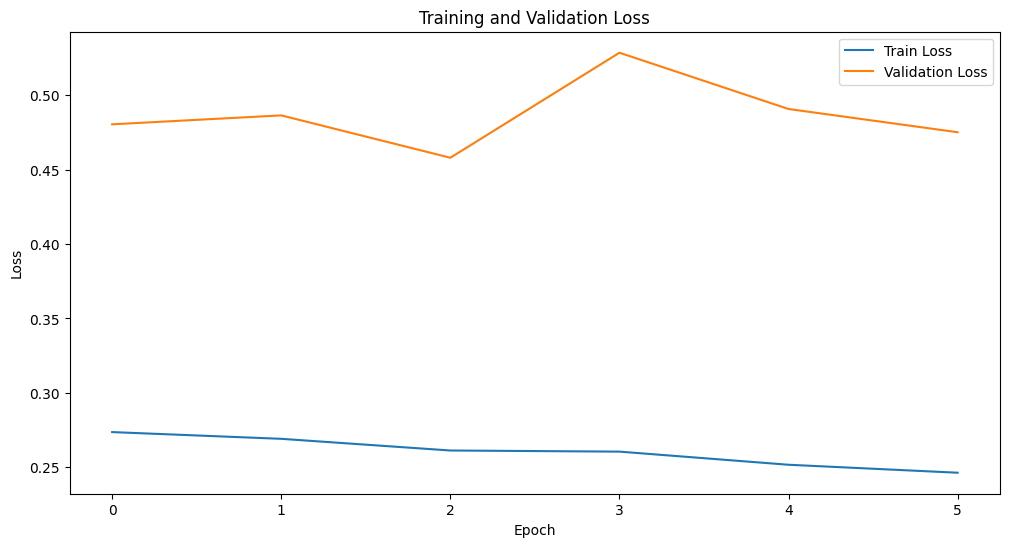

166/166 [==============================] - 1s 7ms/step - loss: 0.4258 - accuracy: 0.8952
Test Loss: 0.4258102476596832
Test Accuracy: 0.8951635956764221
2/2 [==============================] - 0s 11ms/step

Classification Report:
                    precision    recall  f1-score   support

_background_noise_       1.00      1.00      1.00         1
          backward       0.84      0.90      0.87       173
               bed       0.87      0.82      0.84       207
              bird       0.91      0.85      0.88       208
               cat       0.84      0.89      0.87       215
               dog       0.92      0.79      0.85       237
              down       0.89      0.90      0.89       385
             eight       0.92      0.95      0.93       399
              five       0.86      0.89      0.88       379
            follow       0.80      0.80      0.80       157
           forward       0.84      0.79      0.82       170
              four       0.85      0.91      0.88 

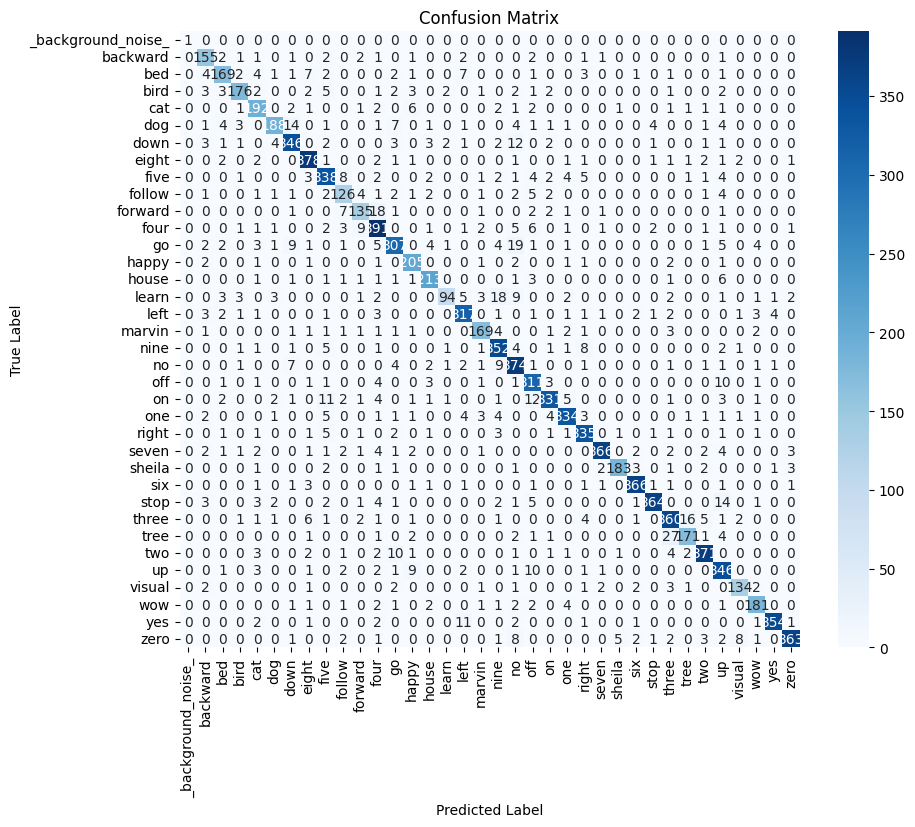

2/2 [==============================] - 0s 4ms/step
Error Analysis (true label, predicted label):
(2, 7)
(11, 24)
(15, 18)
(34, 16)
(9, 30)
(13, 22)
(29, 28)
(1, 20)
(2, 7)
(20, 19)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_history(history)

# Evaluate the model
def evaluate_model(model, test_ds):
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Generate predictions
    y_true = []
    y_pred = []

    for audio, labels in test_ds:
        predictions = model.predict(audio)
        predicted_labels = tf.argmax(predictions, axis=1).numpy()
        y_pred.extend(predicted_labels)
        y_true.extend(labels.numpy())
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(label_names)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(best_model, test_spectrogram_ds)

# Error Analysis
def analyze_errors(model, test_ds):
    errors = []
    for audio, label in test_ds:
        predictions = model.predict(audio)
        predicted_labels = tf.argmax(predictions, axis=1).numpy()
        true_labels = label.numpy()
        for true, pred in zip(true_labels, predicted_labels):
            if true != pred:
                errors.append((true, pred))
    
    # Print a few error samples
    print("Error Analysis (true label, predicted label):")
    for error in errors[:10]:
        print(error)

analyze_errors(best_model, test_spectrogram_ds)


In [25]:
import keras_tuner as kt

# Define the model-building function with hyperparameters
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape)))
    # Add layers based on hyperparameters
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    # Add more layers and compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='resnet_tuning'
)

# Search for the best hyperparameters
tuner.search(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=25)


Reloading Tuner from tuner_dir\resnet_tuning\tuner0.json


In [26]:
# Save the best model
best_model.save('best_model.h5')

# Load the model (when needed)
loaded_model = tf.keras.models.load_model('best_model.h5')


In [27]:
# Load the model without optimizer state
loaded_model = tf.keras.models.load_model('best_model.h5', compile=False)

# Recompile the model with the same optimizer and loss function
loaded_model.compile(optimizer='adam',  # or the optimizer you used
                     loss='sparse_categorical_crossentropy',  # or your loss function
                     metrics=['accuracy'])


In [31]:
# %pip install tensorflow numpy librosa


  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl.metadata (14 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.7 MB 4.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.7 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 4.6 MB/s eta 0:00:00
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached soundfile-0.12.1-py2.py3-none-win_amd64.whl (1.0 MB)
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   - ----

In [84]:
import os
from collections import Counter

def analyze_dataset_structure(root_directory):
    file_paths = []
    labels = []
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(root_directory):
        for file_name in files:
            if file_name.endswith('.wav'):
                file_path = os.path.join(root, file_name)
                label = os.path.basename(os.path.dirname(file_path))
                file_paths.append(file_path)
                labels.append(label)
    
    # Count occurrences of each label
    label_counts = Counter(labels)
    
    return file_paths, labels, label_counts

root_directory = 'processed_recorded_audio'
file_paths, labels, label_counts = analyze_dataset_structure(root_directory)

print(f"Total files: {len(file_paths)}")
print(f"Label distribution: {label_counts}")


Total files: 1538
Label distribution: Counter({'up': 67, 'House': 59, 'Right': 58, 'Four': 57, 'three': 55, 'two': 55, 'Happy': 54, 'Left': 54, 'Stop': 54, 'On': 51, 'One': 51, 'Seven': 51, 'tree': 51, 'Go': 49, 'No': 49, 'Marvin': 47, 'Forward': 46, 'Nine': 46, 'Off': 46, 'Sheila': 46, 'yes': 44, 'Follow': 43, 'Six': 42, 'visual': 42, 'Down': 37, 'Dog': 36, 'Five': 36, 'Backward': 35, 'Eight': 35, 'Bird': 33, 'Bed': 32, 'zero': 31, 'Learn': 29, 'wow': 17})


In [85]:
import librosa

def analyze_audio_files(file_paths):
    sample_rates = []
    durations = []
    
    for file_path in file_paths:
        audio, sr = librosa.load(file_path, sr=None)
        sample_rates.append(sr)
        durations.append(librosa.get_duration(y=audio, sr=sr))
    
    return sample_rates, durations

sample_rates, durations = analyze_audio_files(file_paths)

print(f"Unique sample rates: {set(sample_rates)}")
print(f"Duration statistics: Min={min(durations)}, Max={max(durations)}, Mean={sum(durations)/len(durations)}")


Unique sample rates: {44100}
Duration statistics: Min=2.275873015873016, Max=11.908866213151928, Mean=2.5374543905121616


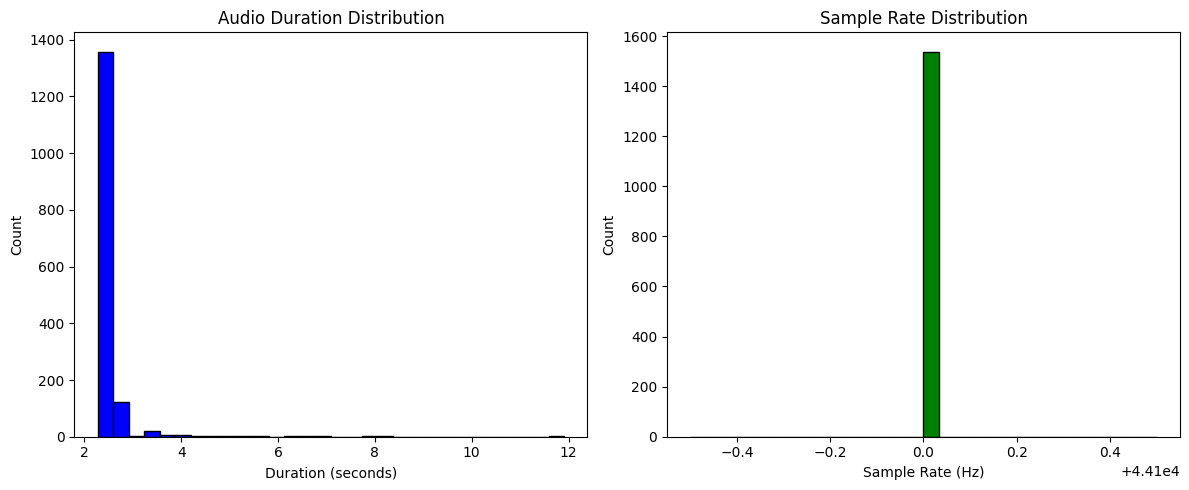

In [86]:
import matplotlib.pyplot as plt

def plot_audio_statistics(durations, sample_rates):
    plt.figure(figsize=(12, 5))
    
    # Plot duration histogram
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=30, color='blue', edgecolor='black')
    plt.title('Audio Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Plot sample rate histogram
    plt.subplot(1, 2, 2)
    plt.hist(sample_rates, bins=30, color='green', edgecolor='black')
    plt.title('Sample Rate Distribution')
    plt.xlabel('Sample Rate (Hz)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

plot_audio_statistics(durations, sample_rates)


In [74]:
import librosa

def print_wav_file_shape(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    print(f"File: {file_path}")
    print(f"Sample Rate: {sr}")
    print(f"Audio Shape: {audio.shape}")

# Example usage: print shape of the first few WAV files
import glob

# Get a list of some WAV files
wav_files = glob.glob('processed_recorded_audio/**/*.wav', recursive=True)
for wav_file in wav_files[:5]:  # Inspect the first 5 files
    print_wav_file_shape(wav_file)


File: processed_recorded_audio\Backward\Backward_01.wav
Sample Rate: 44100
Audio Shape: (112361,)
File: processed_recorded_audio\Backward\Backward_02.wav
Sample Rate: 44100
Audio Shape: (114080,)
File: processed_recorded_audio\Backward\Backward_03.wav
Sample Rate: 44100
Audio Shape: (114478,)
File: processed_recorded_audio\Backward\Backward_04.wav
Sample Rate: 44100
Audio Shape: (113154,)
File: processed_recorded_audio\Backward\Backward_05.wav
Sample Rate: 44100
Audio Shape: (113552,)


In [57]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      5

In [209]:
# import os
# import numpy as np
# import tensorflow as tf
# import librosa
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.models import load_model

# # Function to analyze dataset structure
# def analyze_dataset_structure(root_directory):
#     file_paths = []
#     labels = []
    
#     # Walk through the directory structure
#     for root, dirs, files in os.walk(root_directory):
#         for file_name in files:
#             if file_name.endswith('.wav'):
#                 file_path = os.path.join(root, file_name)
#                 label = os.path.basename(os.path.dirname(file_path))
#                 file_paths.append(file_path)
#                 labels.append(label)
    
#     # Count occurrences of each label
#     label_counts = Counter(labels)
    
#     return file_paths, labels, label_counts

# # Function to analyze audio files
# def analyze_audio_files(file_paths):
#     sample_rates = []
#     durations = []
    
#     for file_path in file_paths:
#         audio, sr = librosa.load(file_path, sr=None)
#         sample_rates.append(sr)
#         durations.append(librosa.get_duration(y=audio, sr=sr))
    
#     return sample_rates, durations

# # Function to plot audio statistics
# def plot_audio_statistics(durations, sample_rates):
#     plt.figure(figsize=(12, 5))
    
#     # Plot duration histogram
#     plt.subplot(1, 2, 1)
#     plt.hist(durations, bins=30, color='blue', edgecolor='black')
#     plt.title('Audio Duration Distribution')
#     plt.xlabel('Duration (seconds)')
#     plt.ylabel('Count')
    
#     # Plot sample rate histogram
#     plt.subplot(1, 2, 2)
#     plt.hist(sample_rates, bins=30, color='green', edgecolor='black')
#     plt.title('Sample Rate Distribution')
#     plt.xlabel('Sample Rate (Hz)')
#     plt.ylabel('Count')
    
#     plt.tight_layout()
#     plt.show()

# # Function to load and preprocess audio
# def load_and_preprocess_audio(file_path, target_sample_rate=16000, target_length=16000):
#     # Load audio file with librosa
#     audio, sample_rate = librosa.load(file_path, sr=None)  # Load the audio file with its original sample rate
    
#     # Resample audio to the target sample rate
#     audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)
    
#     # Ensure the audio tensor is of type float32
#     audio = np.array(audio, dtype=np.float32)
    
#     # Pad or truncate the audio to the target length
#     if len(audio) < target_length:
#         audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
#     else:
#         audio = audio[:target_length]
    
#     return audio

# # Function to load and preprocess voice data
# def load_and_preprocess_voice_data(file_paths, labels, target_sample_rate=16000, target_length=16000):
#     audio_data = []
#     label_data = []
    
#     for file_path, label in zip(file_paths, labels):
#         print(f"Processing file: {file_path}")
#         audio = load_and_preprocess_audio(file_path, target_sample_rate, target_length)
#         print(f"Audio shape after processing: {audio.shape}")
#         audio_data.append(audio)
#         label_data.append(label)
    
#     print(f"Total audio samples processed: {len(audio_data)}")
#     return np.array(audio_data), np.array(label_data)

# def load_and_preprocess_audio(file_path, target_sample_rate=16000):
#     # Load audio file with librosa
#     audio, sample_rate = librosa.load(file_path, sr=None)
    
#     # Resample audio to the target sample rate
#     if sample_rate != target_sample_rate:
#         audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)
    
#     # Convert to TensorFlow tensor
#     audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

#     # Convert to spectrogram
#     spectrogram = tf.signal.stft(audio_tensor, frame_length=256, frame_step=128)
#     spectrogram = tf.abs(spectrogram)  # Magnitude of the complex spectrogram
#     spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], size=[32, 32])  # Resize and add channel dimension
    
#     return spectrogram


# def load_and_preprocess_voice_data(file_paths, labels):
#     audio_data = []
#     for file_path in file_paths:
#         print(f"Processing file: {file_path}")
#         audio = load_and_preprocess_audio(file_path)
#         audio_data.append(audio)
    
#     audio_data = np.array(audio_data)
#     labels = np.array(labels)

#     return audio_data, labels

# # Function to get audio paths and labels
# def get_audio_paths_and_labels(folder_path):
#     audio_paths = []
#     labels = []
    
#     for label in os.listdir(folder_path):
#         label_folder = os.path.join(folder_path, label)
#         if os.path.isdir(label_folder):
#             for file_name in os.listdir(label_folder):
#                 if file_name.endswith('.wav'):
#                     file_path = os.path.join(label_folder, file_name)
#                     audio_paths.append(file_path)
#                     labels.append(label)
    
#     return audio_paths, labels

# # Function to check if files exist
# def check_files(file_paths):
#     for file_path in file_paths:
#         if not os.path.exists(file_path):
#             print(f"File does not exist: {file_path}")
#         else:
#             print(f"File exists: {file_path}")

# # Main execution
# if __name__ == "__main__":
#     # Analyze dataset structure
#     root_directory = 'processed_recorded_audio'
#     file_paths, labels, label_counts = analyze_dataset_structure(root_directory)

#     print(f"Total files: {len(file_paths)}")
#     print(f"Label distribution: {label_counts}")

#     # Analyze audio files
#     sample_rates, durations = analyze_audio_files(file_paths)

#     print(f"Unique sample rates: {set(sample_rates)}")
#     print(f"Duration statistics: Min={min(durations)}, Max={max(durations)}, Mean={sum(durations)/len(durations)}")

#     # Plot audio statistics
#     plot_audio_statistics(durations, sample_rates)

#     # Check files
#     check_files(file_paths)

#     # Load and preprocess voice data
#     voice_audio_data, voice_label_data = load_and_preprocess_voice_data(file_paths, labels)

#     # Convert labels to integer format
#     label_encoder = LabelEncoder()
#     integer_labels = label_encoder.fit_transform(voice_label_data)
#     integer_labels = tf.convert_to_tensor(integer_labels, dtype=tf.int64)

#     # Convert audio data to TensorFlow tensor
#     audio_data = tf.convert_to_tensor(voice_audio_data, dtype=tf.float32)

#     # Load and fine-tune the model
#     pretrained_model_path = 'best_model.h5'
#     model = load_model(pretrained_model_path)

#     # Print model summary to check the architecture
#     model.summary()

#     # Compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Fine-tune the model
#     history = model.fit(
#         audio_data, integer_labels,
#         epochs=10,  # Adjust as needed
#         validation_split=0.2,
#         batch_size=32,
#         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
#     )

#     # Evaluate the model
#     test_loss, test_accuracy = model.evaluate(audio_data, integer_labels)
#     print(f"Test accuracy: {test_accuracy:.2f}")

#     # Save the fine-tuned model
#     model.save('hellomodel.h5')


Total files: 1538
Label distribution: Counter({'up': 67, 'House': 59, 'Right': 58, 'Four': 57, 'three': 55, 'two': 55, 'Happy': 54, 'Left': 54, 'Stop': 54, 'On': 51, 'One': 51, 'Seven': 51, 'tree': 51, 'Go': 49, 'No': 49, 'Marvin': 47, 'Forward': 46, 'Nine': 46, 'Off': 46, 'Sheila': 46, 'yes': 44, 'Follow': 43, 'Six': 42, 'visual': 42, 'Down': 37, 'Dog': 36, 'Five': 36, 'Backward': 35, 'Eight': 35, 'Bird': 33, 'Bed': 32, 'zero': 31, 'Learn': 29, 'wow': 17})
Unique sample rates: {44100}
Duration statistics: Min=2.275873015873016, Max=11.908866213151928, Mean=2.5374543905121616


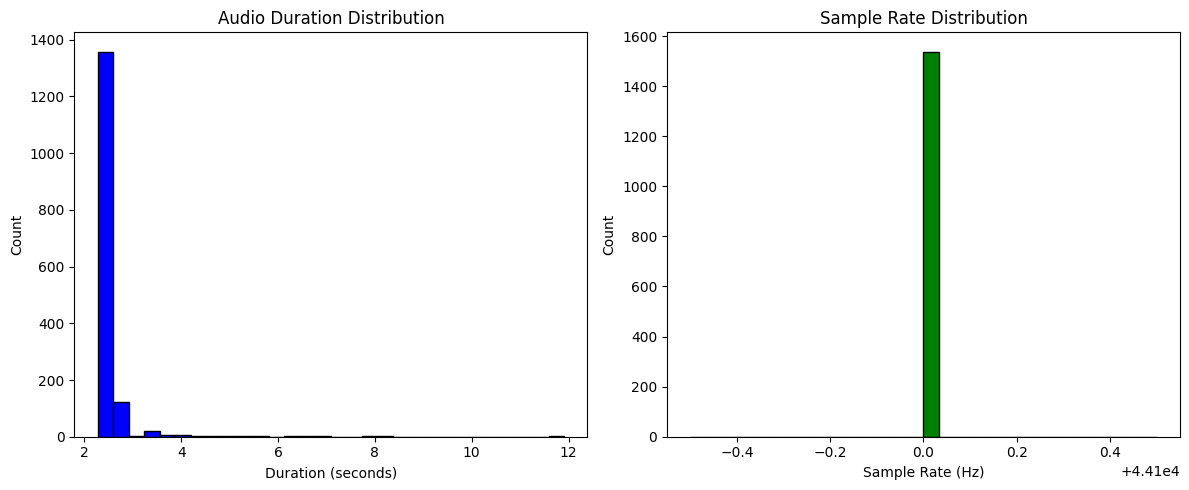

File exists: processed_recorded_audio\Backward\Backward_01.wav
File exists: processed_recorded_audio\Backward\Backward_02.wav
File exists: processed_recorded_audio\Backward\Backward_03.wav
File exists: processed_recorded_audio\Backward\Backward_04.wav
File exists: processed_recorded_audio\Backward\Backward_05.wav
File exists: processed_recorded_audio\Backward\Backward_06.wav
File exists: processed_recorded_audio\Backward\Backward_07.wav
File exists: processed_recorded_audio\Backward\Backward_08.wav
File exists: processed_recorded_audio\Backward\Backward_09.wav
File exists: processed_recorded_audio\Backward\Backward_10.wav
File exists: processed_recorded_audio\Backward\Backward_11.wav
File exists: processed_recorded_audio\Backward\Backward_12.wav
File exists: processed_recorded_audio\Backward\Backward_13.wav
File exists: processed_recorded_audio\Backward\Backward_14.wav
File exists: processed_recorded_audio\Backward\Backward_15.wav
File exists: processed_recorded_audio\Backward\Backward

In [208]:
import os
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from collections import Counter

# Function to analyze dataset structure
def analyze_dataset_structure(root_directory):
    file_paths = []
    labels = []
    
    # Walk through the directory structure
    for root, dirs, files in os.walk(root_directory):
        for file_name in files:
            if file_name.endswith('.wav'):
                file_path = os.path.join(root, file_name)
                label = os.path.basename(os.path.dirname(file_path))
                file_paths.append(file_path)
                labels.append(label)
    
    # Count occurrences of each label
    label_counts = Counter(labels)
    
    return file_paths, labels, label_counts

# Function to analyze audio files
def analyze_audio_files(file_paths):
    sample_rates = []
    durations = []
    
    for file_path in file_paths:
        audio, sr = librosa.load(file_path, sr=None)
        sample_rates.append(sr)
        durations.append(librosa.get_duration(y=audio, sr=sr))
    
    return sample_rates, durations

# Function to plot audio statistics
def plot_audio_statistics(durations, sample_rates):
    plt.figure(figsize=(12, 5))
    
    # Plot duration histogram
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=30, color='blue', edgecolor='black')
    plt.title('Audio Duration Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Plot sample rate histogram
    plt.subplot(1, 2, 2)
    plt.hist(sample_rates, bins=30, color='green', edgecolor='black')
    plt.title('Sample Rate Distribution')
    plt.xlabel('Sample Rate (Hz)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Function to augment audio data
def augment_audio(audio, sample_rate):
    # Time Stretching
    stretch_rate = np.random.uniform(0.8, 1.2)  # Stretch rate between 0.8x and 1.2x
    audio = librosa.effects.time_stretch(audio, rate=stretch_rate)
    
    # Pitch Shifting
    pitch_shift = np.random.randint(-2, 3)  # Shift pitch by -2 to +2 semitones
    audio = librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=pitch_shift)
    
    # Adding Noise
    noise_factor = np.random.uniform(0.005, 0.05)  # Noise factor between 0.005 and 0.05
    noise = np.random.randn(len(audio))
    audio = audio + noise_factor * noise
    
    return audio

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path, target_sample_rate=16000, target_length=16000):
    # Load audio file with librosa
    audio, sample_rate = librosa.load(file_path, sr=None)  # Load the audio file with its original sample rate
    
    # Resample audio to the target sample rate
    audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)
    
    # Augment the audio
    audio = augment_audio(audio, target_sample_rate)
    
    # Ensure the audio tensor is of type float32
    audio = np.array(audio, dtype=np.float32)
    
    # Pad or truncate the audio to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
    else:
        audio = audio[:target_length]
    
    return audio

# Function to convert audio to spectrogram
def audio_to_spectrogram(audio, target_sample_rate=16000):
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)
    
    # Convert to spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)  # Magnitude of the complex spectrogram
    spectrogram = tf.image.resize(spectrogram[..., tf.newaxis], size=[32, 32])  # Resize and add channel dimension
    
    return spectrogram

# Function to load and preprocess voice data
def load_and_preprocess_voice_data(file_paths, labels):
    audio_data = []
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        audio = load_and_preprocess_audio(file_path)
        spectrogram = audio_to_spectrogram(audio)
        audio_data.append(spectrogram)
    
    audio_data = np.array(audio_data)
    labels = np.array(labels)

    return audio_data, labels

# Function to get audio paths and labels
def get_audio_paths_and_labels(folder_path):
    audio_paths = []
    labels = []
    
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if os.path.isdir(label_folder):
            for file_name in os.listdir(label_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(label_folder, file_name)
                    audio_paths.append(file_path)
                    labels.append(label)
    
    return audio_paths, labels

# Function to check if files exist
def check_files(file_paths):
    for file_path in file_paths:
        if not os.path.exists(file_path):
            print(f"File does not exist: {file_path}")
        else:
            print(f"File exists: {file_path}")

# Main execution
if __name__ == "__main__":
    # Analyze dataset structure
    root_directory = 'processed_recorded_audio'
    file_paths, labels, label_counts = analyze_dataset_structure(root_directory)

    print(f"Total files: {len(file_paths)}")
    print(f"Label distribution: {label_counts}")

    # Analyze audio files
    sample_rates, durations = analyze_audio_files(file_paths)

    print(f"Unique sample rates: {set(sample_rates)}")
    print(f"Duration statistics: Min={min(durations)}, Max={max(durations)}, Mean={sum(durations)/len(durations)}")

    # Plot audio statistics
    plot_audio_statistics(durations, sample_rates)

    # Check files
    check_files(file_paths)

    # Load and preprocess voice data
    voice_audio_data, voice_label_data = load_and_preprocess_voice_data(file_paths, labels)

    # Convert labels to integer format
    label_encoder = LabelEncoder()
    integer_labels = label_encoder.fit_transform(voice_label_data)
    integer_labels = tf.convert_to_tensor(integer_labels, dtype=tf.int64)

    # Convert audio data to TensorFlow tensor
    audio_data = tf.convert_to_tensor(voice_audio_data, dtype=tf.float32)

    # Load and fine-tune the model
    pretrained_model_path = 'best_model.h5'
    model = load_model(pretrained_model_path)

    # Print model summary to check the architecture
    model.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tune the model
    history = model.fit(
        audio_data, integer_labels,
        epochs=10,  # Adjust as needed
        validation_split=0.2,
        batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(audio_data, integer_labels)
    print(f"Test accuracy: {test_accuracy:.2f}")

    # Save the fine-tuned model
    model.save('hellomodel.h5')
